Brusselator for exluded volume in 1D

In [11]:
import numpy as np
from scipy.fft import fftn, ifftn, fftfreq
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc
import matplotlib.animation as animation
%matplotlib inline


def create_initial_array(num_of_nodes, ampl = 0.1):
        return (np.random.rand(num_of_nodes)-0.5) * ampl
    #return initial concentration of substance. Can be random, should be positive
def print_stability_conditions(self):
     pass

class Brusselator():
    def __init__(self, N = 100, L = 10*np.pi, a=1.5, b=2.34, eps = 1,D0=2.8, D1=22.4, NUM_STEPS=10**4, dt = 0.005, c=10, method = 'pseudo-spectral'):
        self.N = N
        self.L = L
        self.a = a
        self.b = b
        self.D0 = D0
        self.D1 = D1
        ## parameter for checking model without excluded volume
        self.eps = eps
        self.NUM_STEPS = NUM_STEPS
        self.dt = dt
        self.c = c
        fu = lambda u,v: self.a + (u**2)*v - (self.b+1)*u
        fv = lambda u,v: self.b*u-(u**2)*v
        self.fu = fu
        self.fv = fv
        self.method = method
# code for initializing data, so that the same model can be run for different methods.
        base_state_u = self.a
        base_state_v = self.b/self.a
        # self.initial_data_u = create_initial_array(self.N)+base_state_u
        self.initial_data_u = create_initial_array(self.N)+base_state_u        
        self.initial_data_v = create_initial_array(self.N)+base_state_v
        print_stability_conditions(self)
    def print_parameters(self):
        return f"Simulation for a={self.a},b={self.b},c={self.c} \
         ,NUM_STEPS={self.NUM_STEPS},N={self.N}, D0={self.D0}, D1={self.D1}, dt = {self.dt}, L={self.L}"
    
    def print_parameters_short(self):
        return f"Simulation for a={self.a},b={self.b},c={self.c}, eps={self.eps}, D0={self.D0}, D1={self.D1}"

In [12]:
def create_wavenumber_array(num_modes, L):
    # create array for wavenumbers in scipy format.
    num_modes = num_modes - num_modes%2 # make num of nodes even. Why?
    # this causes the program not to work for odd num_nodes
    # FIX THIS!
    wavenum_array = np.zeros(num_modes)
    wavenum = 2*np.pi/L
    p1 = np.array([(wavenum * i) for i in range(int(num_modes/2))])
    p2 = np.array([wavenum * (-num_modes+n) for n in range(int(num_modes/2), num_modes)])
    wavenum_array = np.concatenate((p1,p2))
    return wavenum_array

def create_time_operator(wavenums, diffusion_coeff, timestep):
    ## create a time evolution operator
    wavenums = wavenums**2
    return np.exp(-(wavenums)*timestep*diffusion_coeff)
def apply_step_fourier(u,operator):
        fft_u = fftn(u)
        fft_u = fft_u*operator
        return ifftn(fft_u).real

# Von Neumann boundary conditions
def apply_boundary_condition(Z):
    Z[1] = Z[0]
    Z[-2] = Z[-1]
    return Z
    
# def periodic_boundary(Z):
#      Z[0]= Z[-1]
#      return Z
def nonlinear_step(main_variable, v, c, wavenums):
    u = main_variable
    R = c-u-v
    mu = -np.log(R)
    ## first derivative
    mu = 1j*wavenums*fftn(mu)
    mu = main_variable*ifftn(mu).real
    ## second derivative
    mu = 1j*wavenums*fftn(mu)
    mu = ifftn(mu).real
    return mu

def calculate_derivative(Z, dx):
    pass

     

In [13]:
def perform_simulation(brusselator_class = Brusselator(), save_full = False):
    a, b, D0, D1 = brusselator_class.a, brusselator_class.b, brusselator_class.D0, brusselator_class.D1
    N, L, NUM_STEPS, dt = brusselator_class.N, brusselator_class.L, brusselator_class.NUM_STEPS, brusselator_class.dt
    method, fu, fv = brusselator_class.method, brusselator_class.fu, brusselator_class.fv
    dx = L / N
    savetimes = [0, NUM_STEPS//2, NUM_STEPS-2]
    c = brusselator_class.c
    eps = brusselator_class.eps

    initial_data_u = brusselator_class.initial_data_u
    initial_data_v = brusselator_class.initial_data_v

    wavenums = create_wavenumber_array(N, L)

    operator_u = create_time_operator(wavenums, D0, dt)
    operator_v = create_time_operator(wavenums, D1, dt)

##initialize data
    u = initial_data_u.copy()
    v = initial_data_v.copy()

    u_saved = []
    v_saved = []
    if save_full == True:
        time = np.empty(NUM_STEPS)
        time[0] = 0
        shape = time.shape+initial_data_u.shape
        conc_u = np.empty(shape)
        conc_v = np.empty(shape)

    for i in range(NUM_STEPS-1):
        if save_full == True:
            conc_u[i] = u.copy()
            conc_v[i] = v.copy()
            time[i] = i*dt

        if save_full == False:
            if i in savetimes:
                u_saved.append(u.copy())
                v_saved.append(v.copy())

## checking progress
        k = 100
        if i%k == 0:
            progress = float(i/NUM_STEPS)
            print(f"Progress: {progress}", end='\r', flush=True)

        if method == 'pseudo-spectral':
            ## 
            nonlin_u = u + (eps*D0*nonlinear_step(u, v, c, wavenums)+fu(u,v))*dt
            nonlin_v = v + (eps*D1*nonlinear_step(v, u, c, wavenums)+fv(u,v))*dt
            ## linear step in fourier domain
            u = apply_step_fourier(nonlin_u, operator_u)
            v = apply_step_fourier(nonlin_v, operator_v)

            # ## Von Neumann boundary conditions
            # u = apply_boundary_condition(u)
            # v = apply_boundary_condition(v)

    if save_full == True:
        return time, conc_u, conc_v
    else:
        return u_saved, v_saved


In [14]:
import os
import datetime
def save_plot(fig, folder="plots"):
    """ Save the given plot figure with a filename that includes the current date and time. """
    if not os.path.exists(folder):
        os.makedirs(folder)
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = os.path.join(folder, f"plot_{current_time}.png")
    fig.savefig(filename)
    print(f"Plot saved as {filename}")

In [15]:
### 1D ###

def plot_Turing(data,brusselator, save = False):
    L = brusselator.L
    N = brusselator.N
    NUM_STEPS = brusselator.NUM_STEPS
    time=[0,NUM_STEPS//2,NUM_STEPS-2]
    xs = np.arange(0.0,L,L/N)
    # Plot u(x) for different time points
    color=['black','blue','red']
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    fig.suptitle(brusselator.print_parameters_short())
    indices=[0, 1, 2]
    ax1.plot(xs,brusselator.a *np.ones((N,1)))
    for i in indices:
        ax1.plot(xs, data[i], label = time[i], c=color[i])
    ax1.legend()
    if save==True:
        save_plot(fig)
    plt.show()
    # br.print_parameters()

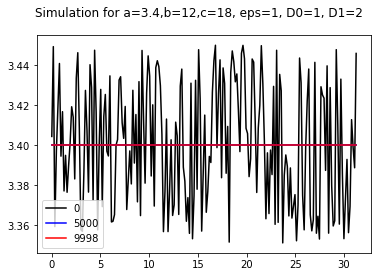

In [16]:
D0,D1 = 1, 2
a=3.4
c=18
b=13.1
br = Brusselator(a=a,b= 12, c=c, D0=D0, D1=D1, N=200 ,NUM_STEPS=10**4, dt=0.005)
br.eps=1
u,v= perform_simulation(br)
plot_Turing(u,br)

In [17]:
def plot_max_amplitude(t, u_sol, v_sol, brusselator=None, save=False):
    """Plot the maximum amplitude of u and v over time."""
    max_u = np.max(u_sol, axis=1)
    max_v = np.max(v_sol, axis=1)
    N = len(max_u)-2
    t = t[:N]; max_u = max_u[:N]; max_v = max_v[:N]
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    axs[0].plot(t, max_u, label='Max amplitude of u')
    axs[0].set_title('Maximum Amplitude of u Over Time')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Maximum Amplitude')
    axs[0].grid(True)
    axs[0].legend()
    
    ##plot ampllitude of v
    axs[1].plot(t, max_v, label='Max amplitude of v', color='orange')
    axs[1].set_title('Maximum Amplitude of v Over Time')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Maximum Amplitude')
    axs[1].grid(True)
    axs[1].legend()
    
    fig.suptitle(brusselator.print_parameters_short())
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    if save:
        save_plot(fig, folder='oscillations')


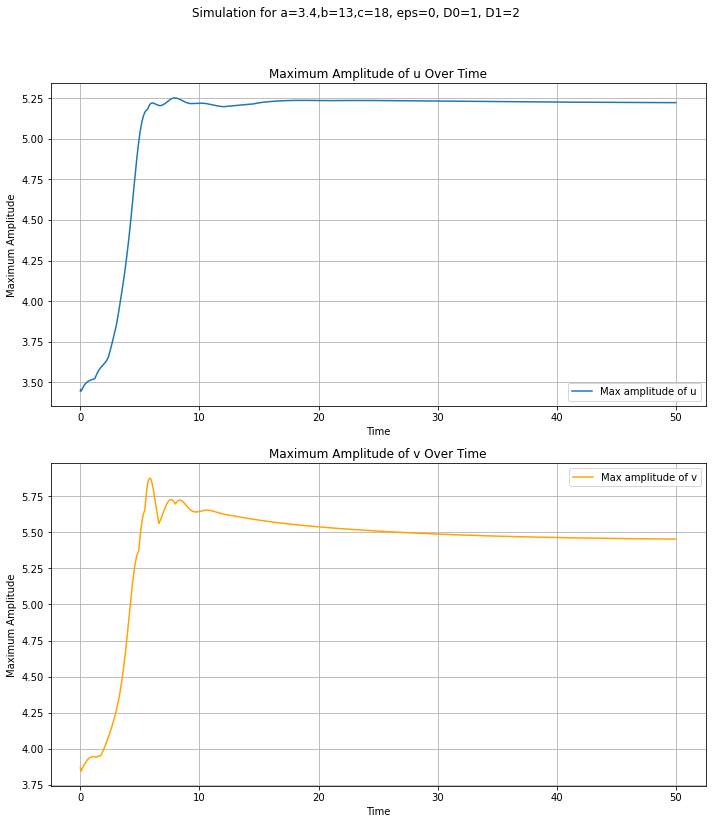

In [18]:

D0,D1 = 1, 2
a=3.4
c=18
b=13
save = False
br_oscillate = Brusselator(a=a, b =b ,D0=D0, D1=D1, c=c, eps=0, NUM_STEPS=10**4)
t,u_sol, v_sol = perform_simulation(br_oscillate,save_full=True)
plot_max_amplitude(t,u_sol,v_sol,br_oscillate, save=save)


In [19]:
## Plot u(x,y) as animation (2D)
import datetime
import os
time, u, v = perform_simulation(br, save_full=True)
## less data to show
u = u[::4]

xs = np.arange(0.0,L,L/N)
base=br.a *np.ones((N,1))
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
folder = "animations_excluded_volume"
if not os.path.exists(folder):
    os.makedirs(folder)
filename = os.path.join(folder, f"brusselator_evolution_{current_time}.mp4")
    

fig  = plt.figure()
fig.suptitle(br.print_parameters_short())
ax   = plt.subplot(111)
ax.set_ylim(0,2*br.a)
i=0

def animate(i):
    ax.cla()
    fond = ax.plot(xs,u[i])
    fond = ax.plot(xs,base)
    fond = ax.set_ylim(0,2*br.a)

    return fond

# anim = animation.FuncAnimation(fig, animate, frames=range(u.shape[0]), interval=100, repeat_delay=1000)
# rc('animation', html='jshtml')

# anim.save(filename, writer='ffmpeg')
# print(f"Animation saved as {filename}")

plt.close(anim._fig)
# HTML(anim.to_jshtml())


NameError: name 'L' is not defined

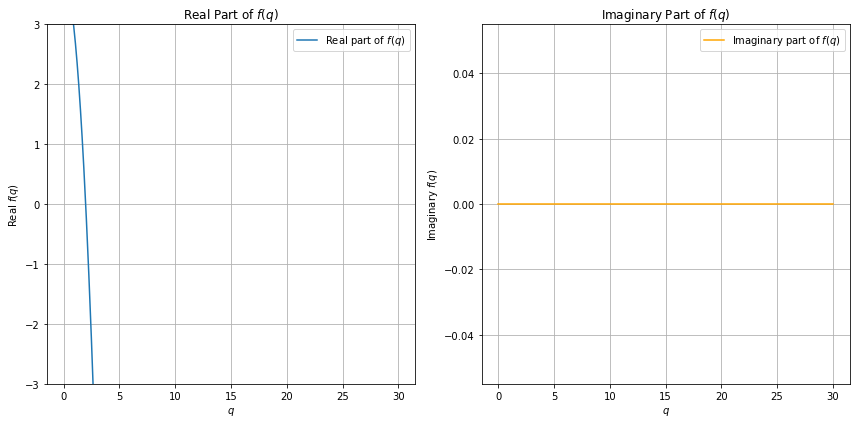

In [ ]:
## printing crossrate
import numpy as np
import matplotlib.pyplot as plt

def compute_A_q(A, B, q):
    """ Compute the matrix A_q = A - q^2 B. """
    return A - q**2 * B

def compute_trace(A_q):
    """ Compute the trace of a matrix. """
    return np.trace(A_q)

def compute_determinant(A_q):
    """ Compute the determinant of a matrix. """
    return np.linalg.det(A_q)

def compute_f(A, B, q):
    """ Compute the function f(q) = 1/2 (tr A_q + sqrt(tr^2 A_q - 4 det A_q)). """
    A_q = compute_A_q(A, B, q)
    tr_A_q = compute_trace(A_q)
    det_A_q = compute_determinant(A_q)
    inside_sqrt = tr_A_q**2 - 4 * det_A_q
    return 0.5 * (tr_A_q + np.lib.scimath.sqrt(inside_sqrt))

def plot_function(A, B, q_range):
    """ Plot the function f(q). """
    f_values = [compute_f(A, B, q) for q in q_range]
    f_values = np.array(f_values)
    
    real_parts = np.real(f_values)
    imag_parts = np.imag(f_values)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(q_range, real_parts, label=r'Real part of $f(q)$')
    plt.title('Real Part of $f(q)$')
    plt.xlabel(r'$q$')
    plt.ylabel(r'Real $f(q)$')
    plt.ylim(-3,3)
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(q_range, imag_parts, label=r'Imaginary part of $f(q)$', color='orange')
    plt.title('Imaginary Part of $f(q)$')
    plt.xlabel(r'$q$')
    plt.ylabel(r'Imaginary $f(q)$')
    # plt.ylim(-3,3)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define example matrices A and B
# A = np.array([[1, 2], [3, 4]])
# B = np.array([[5, 6], [7, 8]])

# Define the range of q values
q_range = np.linspace(0, 30, 400)



brus = Brusselator(a=1,b=6,c=20, D1=1)
a, b, D0, D1 = brus.a, brus.b, brus.D0, brus.D1
c = brus.c
N,L = brus.N, brus.L
u=a; v=b/a
R=c-u-v
A = np.array([
    [(b-1), a**2],
    [(-b), (-a**2)]
])
B = np.array([
    [(u + R)/R, u/R],
    [D1*v/R,D1*(R + v)/R]
])

# Plot the function
plot_function(A, B, q_range)


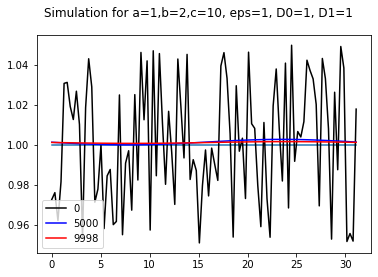

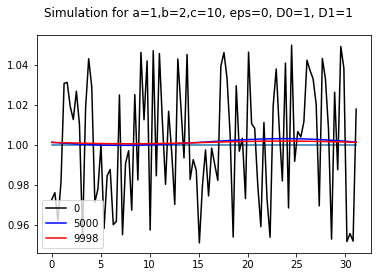

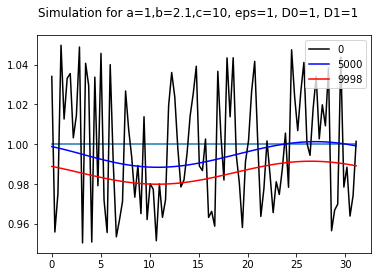

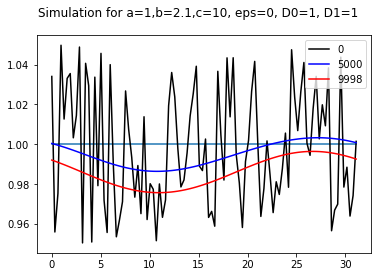

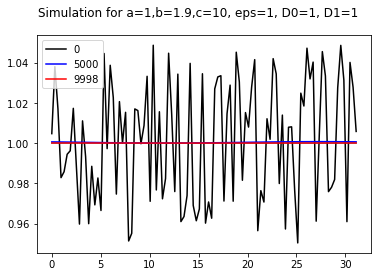

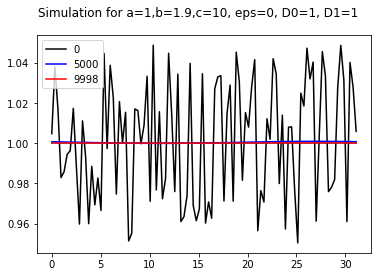

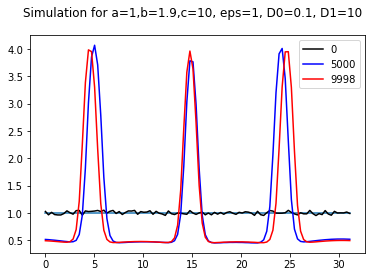

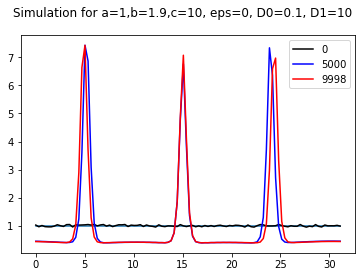

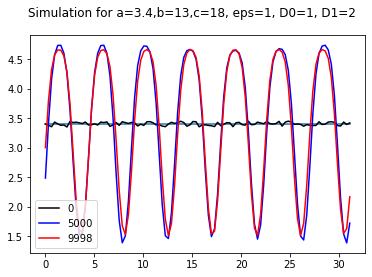

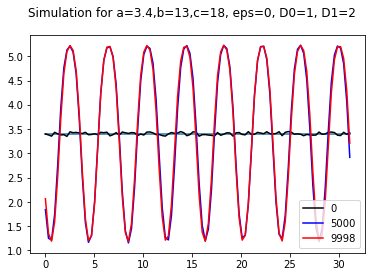

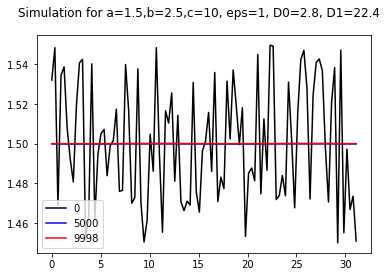

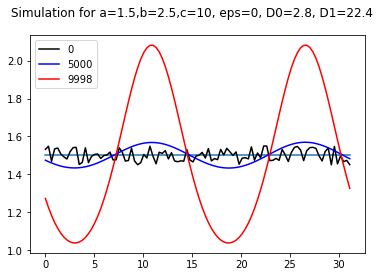

In [30]:
#Redoing all plots
#every list of parameters has the format
# a,b,c,D0,D1
import time
parameters = [[1,2,10,1,1],[1,2.1,10,1,1],[1,1.9,10,1,1],[1,1.9,10,0.1,10],[3.4,13,18,1,2],[1.5,2.5,10,2.8,22.4]]
for i in parameters:
    a,b,c,D0,D1 = i
    bruss = Brusselator(a=a,b=b,c=c,D0=D0,D1=D1)
    
    time.sleep(1)
    u,v = perform_simulation(bruss)
    plot_Turing(u, bruss, save=False)
    bruss.eps=0
    u,v = perform_simulation(bruss)
    plot_Turing(u, bruss, save=False)   

